# Laboratorium 2

# Ćwiczenie - otoczka wypukła

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy
[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

## Zadania
### 1. Przygotuj program generujący następujące zbiory punktów na płaszczyźnie (współrzędne rzeczywiste typu double).
### 2. Uruchom wizualizację graficzną utworzonych zbiorów punktów.
### 3. Zmodyfikuj program z punktu 1 tak, aby możliwe było zadawanie określonych parametrów dla schematów losowania punktów podanych powyżej:
#### a) liczba punktów, przedziały dla współrzędnych,
#### b) liczba punktów, środek i promień okręgu,
#### c) liczba punktów, wierzchołki prostokąta,
#### d) wierzchołki kwadratu, liczba punktów na osiach, liczba punktów na przekątnych.

In [3]:
import random 
import math
from random import randint
from random import uniform

#### 1 a) zbiór zawierający 100 losowo wygenerowanych punktów o współrzędnych z przedziału [-100, 100]

In [4]:
def generate_random(amount,minimum,maximum):
    points=[(uniform(minimum,maximum),uniform(minimum,maximum)) for i in range (amount)]
    return points
points1=generate_random(100,-100,100)

#### Wizualizacja graficzna zbioru a)

<IPython.core.display.Javascript object>


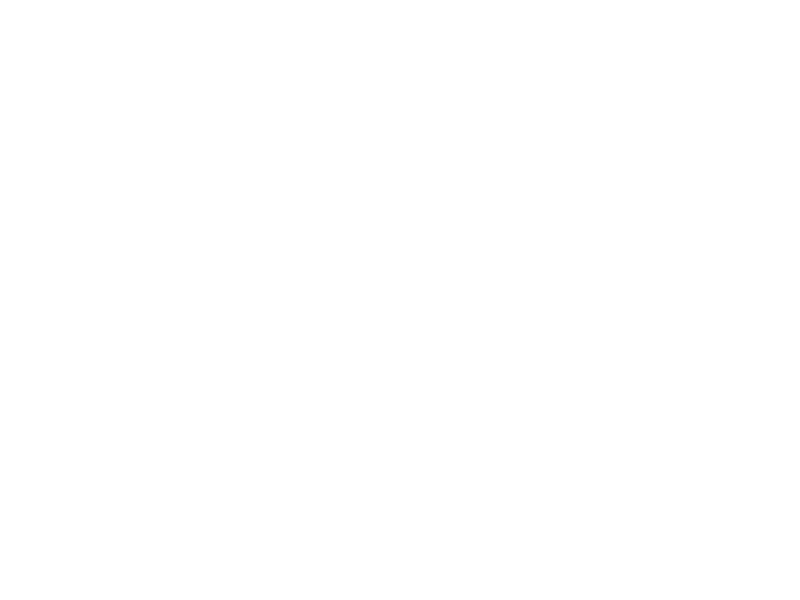

In [5]:
%matplotlib notebook
plot = Plot(points=[PointsCollection(points1,color='indianred')])
plot.draw()

#### 1 b) zbiór zawierający 100 losowo wygenerowanych punktów leżących na okręgu o środku (0,0) i promieniu R=10

In [6]:
def generate_on_circle(amount,center,radius):
    points=[]
    for i in range (amount):
        t=2*math.pi*random.random()
        points.append((center[0]+radius*math.sin(t),center[1]+radius*math.cos(t)))
    return points
points2=generate_on_circle(100,(0,0),10)

#### Wizualizacja graficzna zbioru b)

<IPython.core.display.Javascript object>


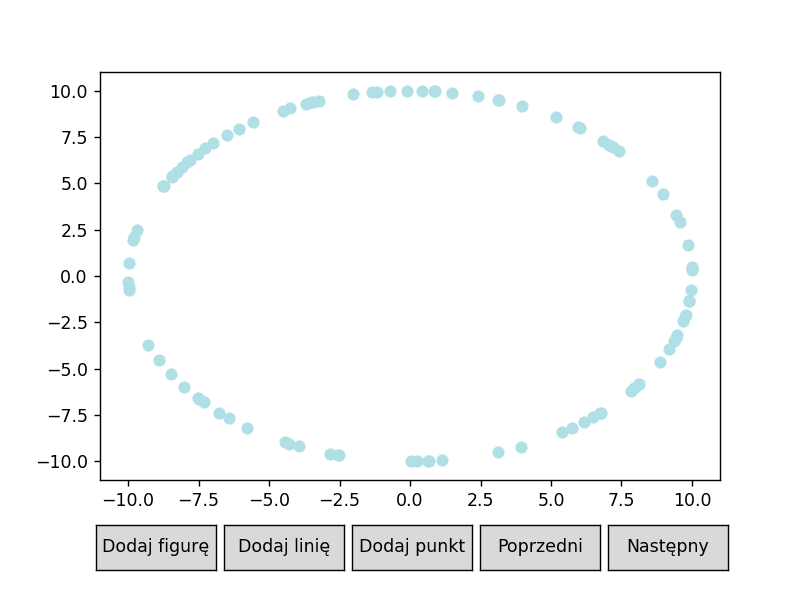

In [7]:
%matplotlib notebook    
plot = Plot(points=[PointsCollection(points2,
color='powderblue')])
plot.draw()

#### 1 c) zbiór zawierający 100 losowo wygenerowanych punktów leżących na bokach prostokąta o wierzchołkach (-10, 10), (-10,-10), (10,-10), (10,10)

In [8]:
def generate_on_rectangle(amount,lowerleft,upperleft,lowerright,upperright):
    points=[]
    #wybiary prostokąta
    for i in range (amount):
        p=randint(0,3)
        if(p==0):
            #0-(lowerleft[0],y)
            w=uniform(lowerleft[1],upperleft[1])
            points.append((lowerleft[0],w))
        elif(p==1):
            #1-(x,lowerleft[1])
            w=uniform(lowerleft[0],lowerright[0])
            points.append((w,lowerleft[1]))
        elif(p==2):
            #2-(upperright[0],y)
            w=uniform(lowerright[1],upperright[1])
            points.append((upperright[0],w))
        else:
            #3-(x,upperright[1])
            w=uniform(upperleft[0],upperright[0])
            points.append((w,upperright[1]))
    return points
points3=generate_on_rectangle(100,(-10,-10),(-10,10),(10,-10),(10,10))

#### Wizualizacja graficzna zbioru c)

<IPython.core.display.Javascript object>


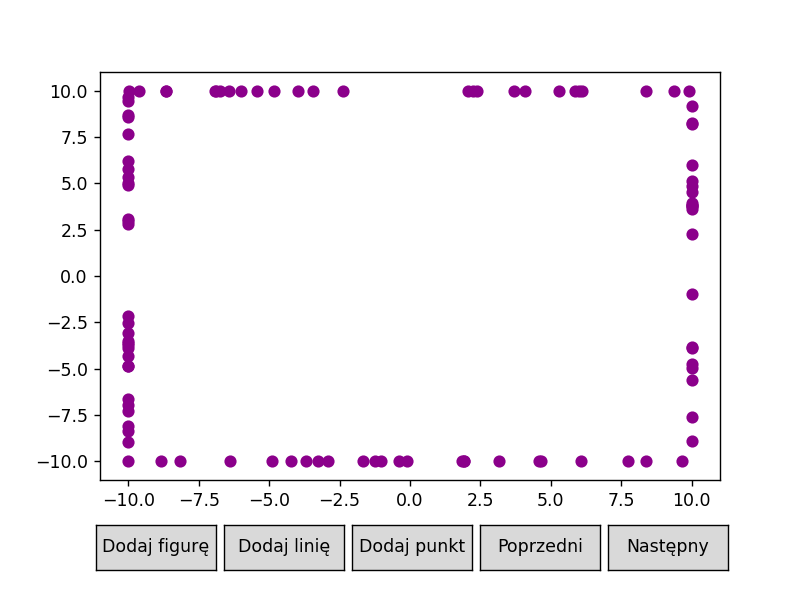

In [9]:
%matplotlib notebook
plot = Plot(points=[PointsCollection(points3,
color='darkmagenta')])
plot.draw()

#### 1 d) zbiór zawierający wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty wygenerowane losowo w sposób następujący: po 25 punktów na dwóch bokach kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu.

In [10]:
def generate_on_square(amount_on_axes,amount_on_diagonal,lowerleft,upperleft,lowerright,upperright):
    points=[]
    #długość boku kwadratu
    a=upperright[0]-upperleft[0]
    
    points.append(lowerleft)
    points.append(upperleft)
    points.append(lowerright)
    points.append(upperright)
    
    #na osiach
    for i in range (amount_on_axes):
        #na osi y
        w1=uniform(0,a)
        points.append((w1,0))
        #na osi x
        w2=uniform(0,a)
        points.append((0,w2))
    #na przekątnych
    for i in range(amount_on_diagonal):
        w1=uniform(lowerleft[0],upperright[0])
        w2=uniform(lowerleft[0],upperright[0])
        points.append((w1,w1))
        points.append((w2,upperright[0]-lowerleft[0]-w2))
    return points
points4=generate_on_square(25,20,(0,0),(0,10),(10,0),(10,10))

#### Wizualizacja graficzna zbioru d)

<IPython.core.display.Javascript object>


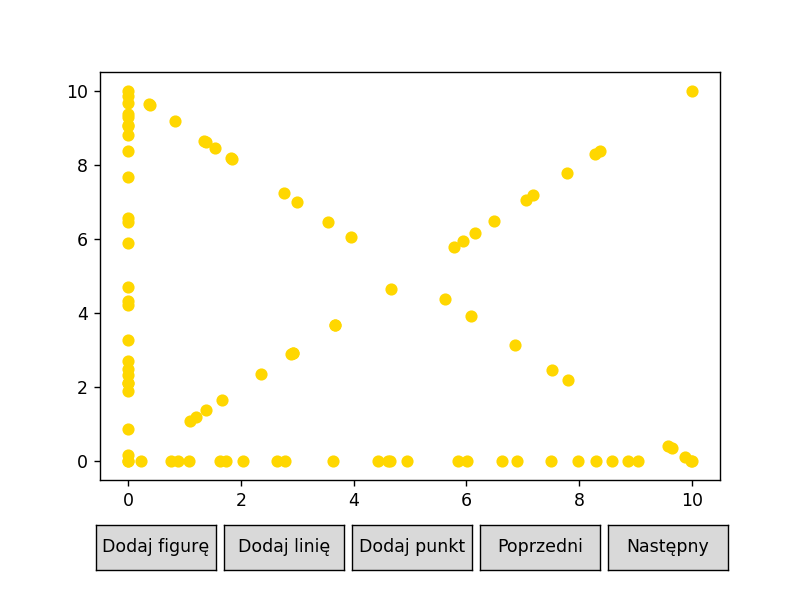

In [11]:
%matplotlib notebook
plot = Plot(points=[PointsCollection(points4,color='gold')])
plot.draw()

#### Zmodyfikowane zbiory z punktu 1

#### 3 a) zbiór zawierający 75 losowo wygenerowanych punktów o współrzędnych z przedziału [-50, 65]

<IPython.core.display.Javascript object>


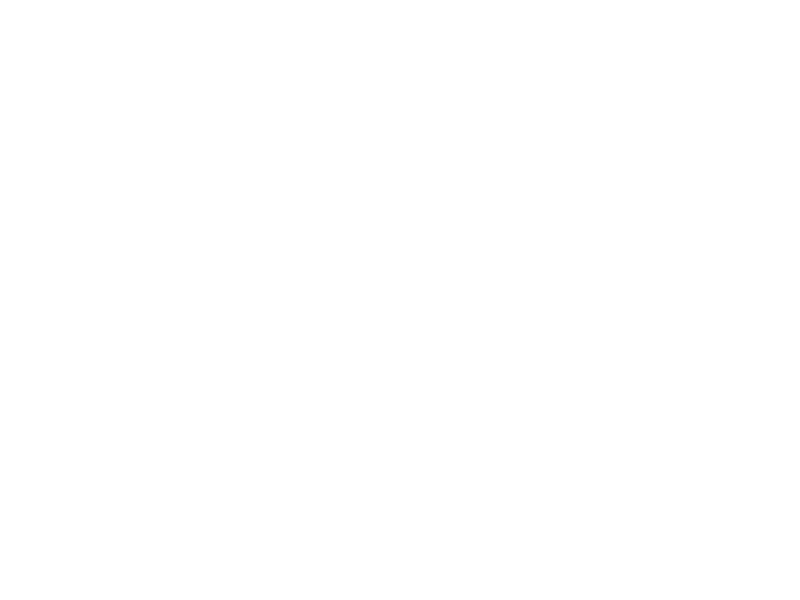

In [12]:
%matplotlib notebook
points5=generate_random(75,-50,65)
plot = Plot(points=[PointsCollection(points5,
color='mediumspringgreen')])

plot.draw()

#### 3 b) zbiór zawierający 50 losowo wygenerowanych punktów leżących na okręgu o środku (5,5) i promieniu R=15

<IPython.core.display.Javascript object>


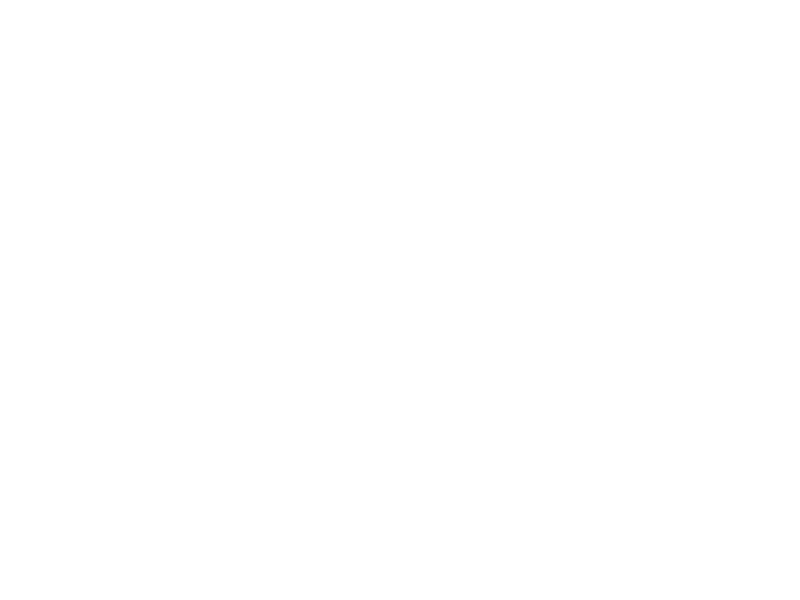

In [13]:
%matplotlib notebook
points6=generate_on_circle(50,(5,5),15)
plot = Plot(points=[PointsCollection(points6,
color='chocolate')])

plot.draw()

#### 3 c) zbiór zawierający 150 losowo wygenerowanych punktów leżących na bokach prostokąta o wierzchołkach (-50, 0), (-50,25), (40,0), (40,25)

<IPython.core.display.Javascript object>


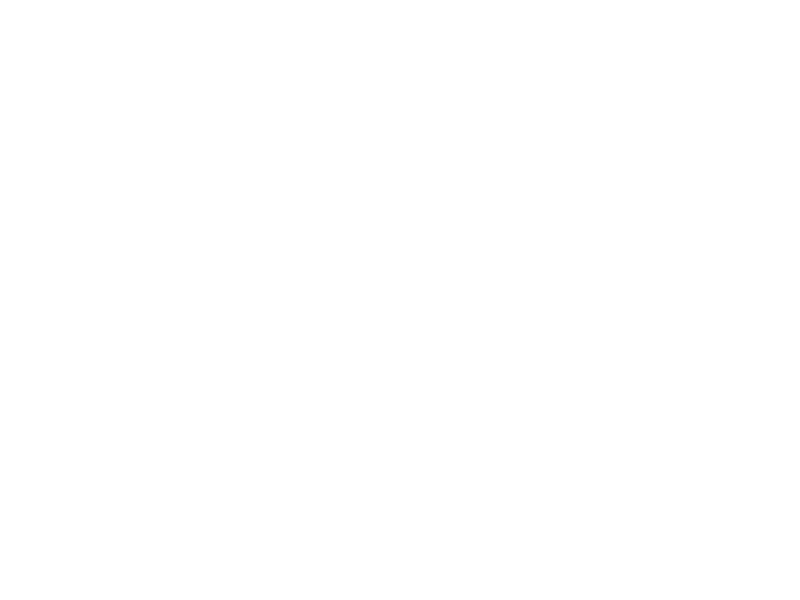

In [14]:
%matplotlib notebook
points7=generate_on_rectangle(150,(-50,0),(-50,25),(40,0),(40,25))
plot = Plot(points=[PointsCollection(points7,
color='hotpink')])

plot.draw()

#### 3 d) zbiór zawierający wierzchołki kwadratu (0, 0), (0, 30), (30, 0), 30, 30) oraz : po 10 punktów na dwóch bokach kwadratu leżących na osiach i po 30 punktów na przekątnych kwadratu.

<IPython.core.display.Javascript object>


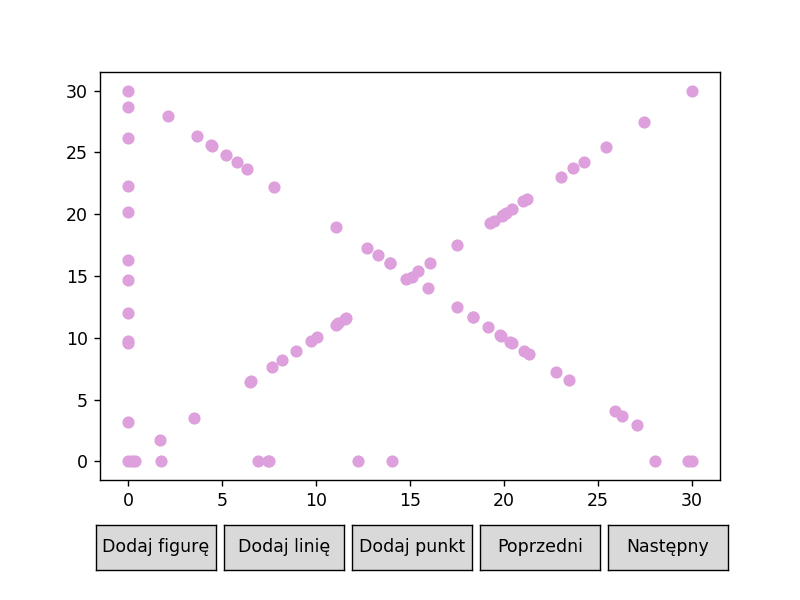

In [15]:
%matplotlib notebook
points8=generate_on_square(10,30,(0,0),(0,30),(30,0),(30,30))
plot = Plot(points=[PointsCollection(points8,
color='plum')])

plot.draw()

### 4. Zaimplementuj algorytmy Grahama oraz Jarvisa wyznaczające otoczkę wypukłą dla zadanego zbioru punktów. Przetestuj program na zbiorach z punktu 1 oraz zmodyfikowanych zbiorach z punktu 3. 

#### Program powinien pozwolić na zapisanie w pliku wyniku działania, czyli ciągu wierzchołków otoczki. Dodaj możliwość sprawdzenia czasu działania algorytmu. Uruchom aplikację graficzną tak, aby można było zilustrować graficznie poszczególne kroki realizacji algorytmu. Jednym kolorem powinny być zaznaczone wszystkie punkty zbioru wyjściowego, drugim kolorem boki aktualnie rozpatrywane, a trzecim boki wielokąta otoczki. Po zakończeniu wyznaczania otooczki wierzchołki otoczki powinny być wyróżnione (osobnym kolorem bądź kształtem).

### Algorytm Grahama

In [16]:
import functools
import time

In [17]:
# Iloczyn skalarny wektorów
def scalar_prod(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1]
# Długość wektora
def length(v):
    return np.sqrt(scalar_prod(v, v))

# Tworzenie wektora na podstawie punktów
def getvec(a, b):
    return b[0] - a[0], b[1] - a[1]

#wyznacznik 2x2
def det2x2(a, b, c,e):
    det = (c[0] - a[0]) * (c[1] - b[1]) -(c[1] - a[1]) * (c[0] - b[0])
    if det > e:
        return 1
    if det < -e:
        return -1
    else:
        return 0

def findlowest(p1, p2):
    if p1[1] < p2[1]:
        return p1
    elif p1[1] > p2[1]:
        return p2
    elif p1[0] < p2[0]:
        return p1
    else:
        return p2

def minimumangle(a, b, c, e=10**(-12)):
    det1 = det2x2(a, b, c, e)
    det2 = det2x2(a, c, b, e)
    if det1 == det2:
        if length(getvec(a, b)) > length(getvec(a, c)):
            return b
        else:
            return c
    #b 
    if det1 > e:
        return b
    return c

In [22]:
def compare_angles(a, b, c, e=10**(-12)):
    if a == b:
        return -1
    if a == c:
        return 1
    det1 = det2x2(a, b, c, e)
    det2 = det2x2(a, c, b, e)
    if det1 == det2:
        if length(getvec(a, b)) > length(getvec(a, c)):
            return -1
        else:
            return 1
    if det1 > e:
        return -1
    return 1


def Graham(points, create_scenes, write_to_file=False):
    #znajdywanie punktu położonego najniżej
    lowest_point = functools.reduce(lambda p1, p2: findlowest(p1, p2), points)
    #sortowanie punktów ze względu na kąt między dodatnim kierunkiem osi x, a wektorem p1,p2
    #-1 - p1 1 -p2
    sorted_points = sorted(points, key=functools.cmp_to_key(lambda p1, p2: compare_angles(lowest_point, p1, p2)))
    #usuwanie punktów o takim samym kącie
    distinct_points = [sorted_points[0], sorted_points[1]]
    len1=len(sorted_points)
    for i in range(2, len1):
        det1 = det2x2(lowest_point, sorted_points[i-1], sorted_points[i], 10**(-12))
        det2 = det2x2(lowest_point, sorted_points[i], sorted_points[i-1], 10**(-12))
        if det1!=det2:
            distinct_points.append(sorted_points[i])
    scenes=[]
    if create_scenes:
        scenes.append(Scene([PointsCollection(points),PointsCollection([lowest_point],color='yellow')]))
    stack = []
    stack.append(distinct_points[0])
    stack.append(distinct_points[1])
    stack.append(distinct_points[2])
    i = 3
    t = 2
    len2=len(distinct_points)
    while i < len2:
        if create_scenes:
            curr_stack=[]
            stack_lines=[]
            n=len(stack)
            for j in range(n):
                curr_stack.append(stack[j])
                if j<n-1:
                    stack_lines.append((stack[j],stack[j+1]))
        
            scenes.append(Scene([PointsCollection(points),PointsCollection(curr_stack,color='yellow'),
            PointsCollection([stack[t - 1], stack[t], distinct_points[i]], color='red', marker='x')],
            [LinesCollection(stack_lines,color='yellow')]))
        if (det2x2(stack[t - 1], stack[t], distinct_points[i], 10**(-12))) > 0:
            stack.append(distinct_points[i])
            t += 1
            i += 1
        else:
            stack.pop()
            t -= 1
    if create_scenes:
        stack_lines=[]
        n=len(stack)
        for j in range (n-1):
            stack_lines.append((stack[j],stack[j+1]))
            stack_lines.append((stack[len(stack)-1],stack[0]))
        scenes.append(Scene([PointsCollection(points),PointsCollection(stack,color='yellow')],
        [LinesCollection(stack_lines,color='yellow')]))

    if write_to_file:
        with open('otoczka.json', 'w+') as f:
            plot=Plot(points=[PointsCollection(stack)])
            f.write(plot.toJson())
    return stack, scenes

#### zbiór 1 a)

<IPython.core.display.Javascript object>


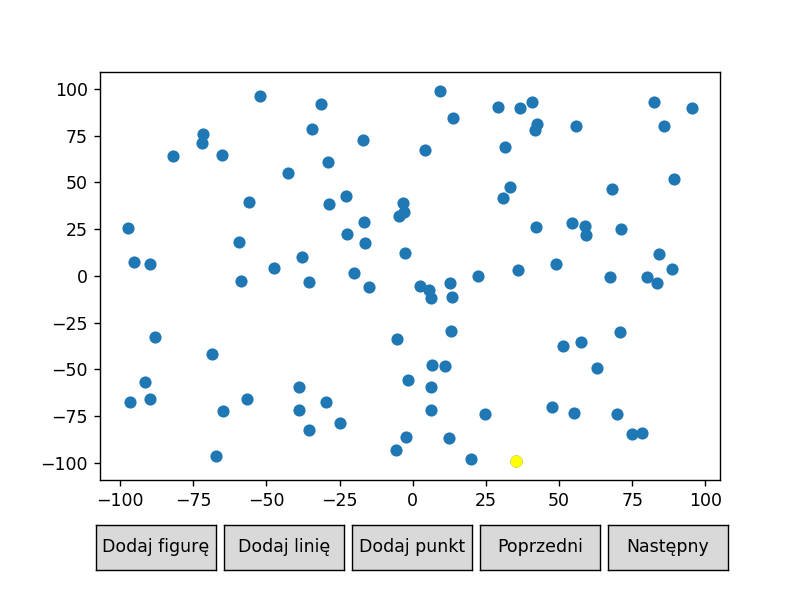

In [23]:
scenes = Graham(points1,True)[1]
plot = Plot(scenes)
plot.draw()

In [253]:
start = time.time()
stack = Graham(points1,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0029993057250976562


#### zbiór 1 b)

<IPython.core.display.Javascript object>


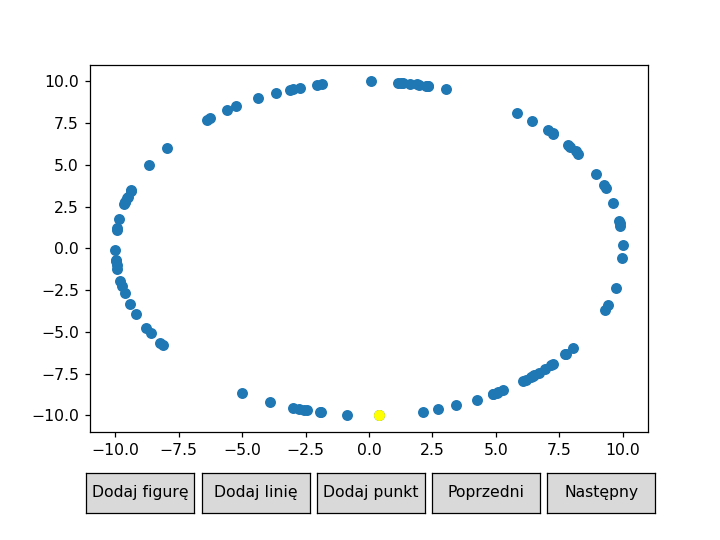

In [255]:
scenes = Graham(points2,True)[1]
plot = Plot(scenes)
plot.draw()

In [256]:
start = time.time()
stack = Graham(points2,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0030014514923095703


#### zbiór 1 c)

<IPython.core.display.Javascript object>


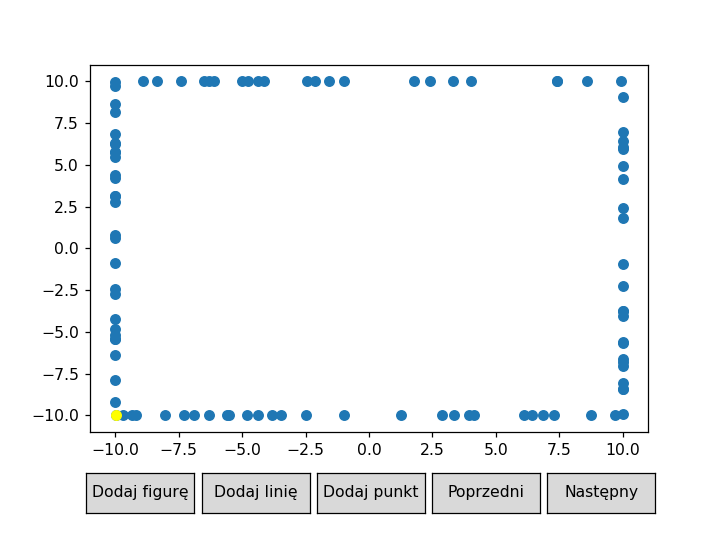

In [258]:
scenes = Graham(points3,True)[1]
plot = Plot(scenes)
plot.draw()

In [259]:
start = time.time()
stack = Graham(points3,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.005003452301025391


#### zbiór 1 d)

<IPython.core.display.Javascript object>


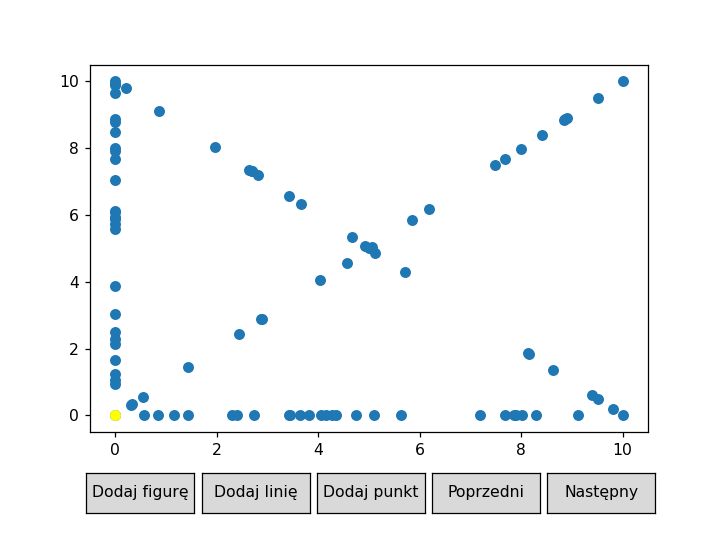

In [260]:
scenes = Graham(points4,True)[1]
plot = Plot(scenes)
plot.draw()

In [261]:
start = time.time()
stack = Graham(points4,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.003000974655151367


#### zbiór 3 a)

<IPython.core.display.Javascript object>


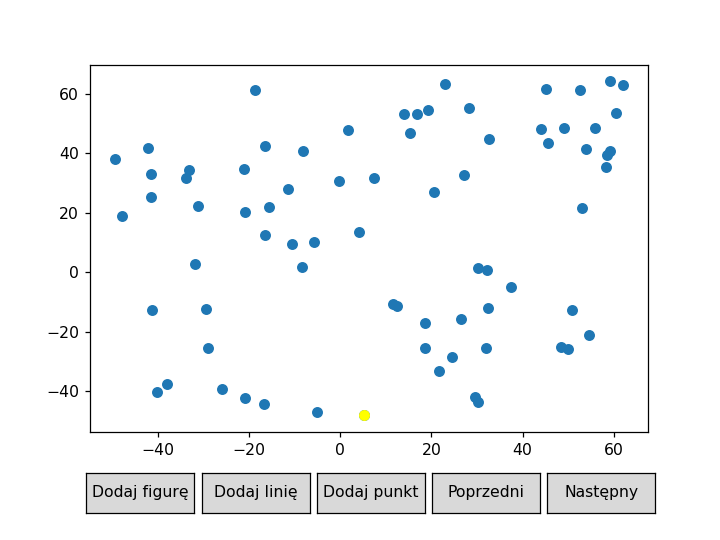

In [263]:
scenes = Graham(points5,True)[1]
plot = Plot(scenes)
plot.draw()

In [264]:
start = time.time()
stack = Graham(points5,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0010008811950683594


#### zbiór 3 b)

<IPython.core.display.Javascript object>


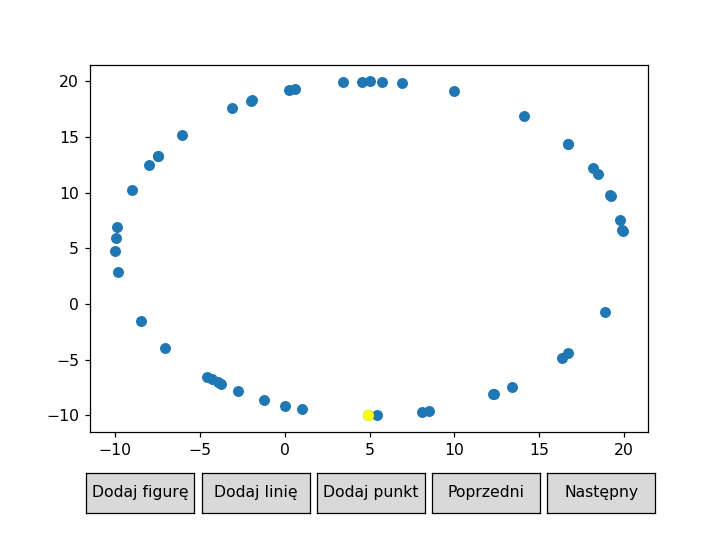

In [265]:
scenes = Graham(points6,True)[1]
plot = Plot(scenes)
plot.draw()

In [266]:
start = time.time()
stack = Graham(points6,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0010001659393310547


#### zbiór 3 c)

<IPython.core.display.Javascript object>


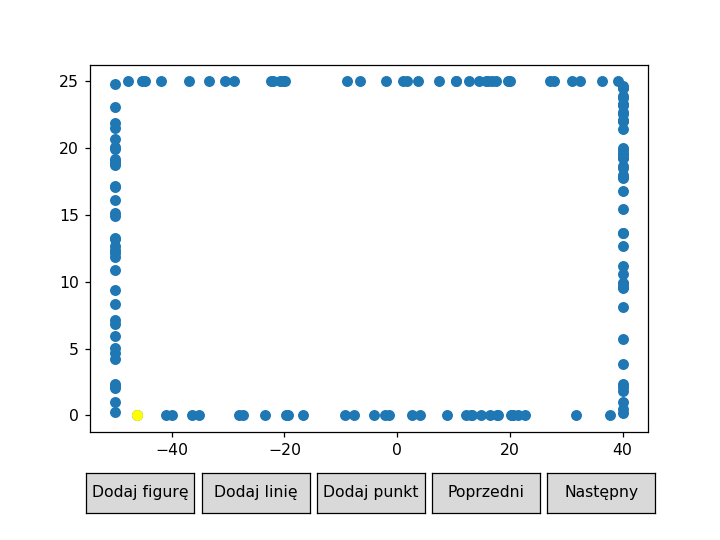

In [267]:
scenes = Graham(points7,True)[1]
plot = Plot(scenes)
plot.draw()

In [268]:
start = time.time()
stock = Graham(points7,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.007004261016845703


#### zbiór 3 d)

<IPython.core.display.Javascript object>


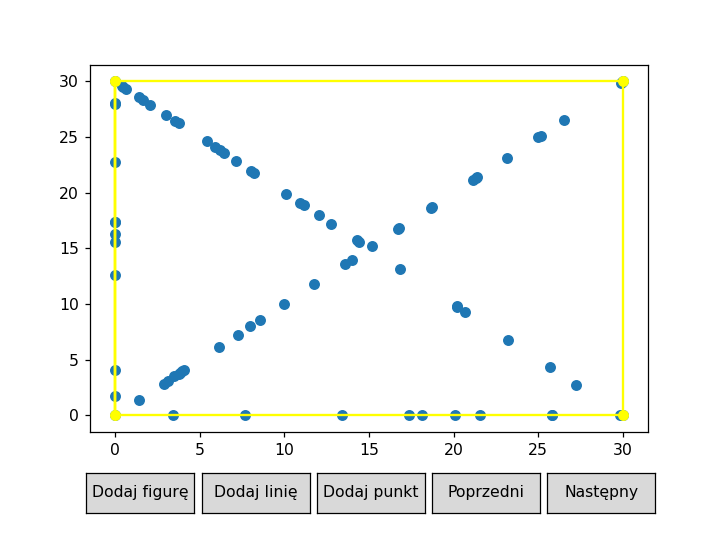

In [269]:
scenes = Graham(points8,True)[1]
plot = Plot(scenes)
plot.draw()

In [270]:
start = time.time()
stock = Graham(points8,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0040035247802734375


### Algorytm Jarvisa

In [271]:

def Jarvis(points,create_scenes, write_to_file=False):
    lowest_point = functools.reduce(lambda p1, p2: findlowest(p1, p2), points)
    stack = [lowest_point]
    scenes=[]
    if create_scenes:
        scenes.append(Scene([PointsCollection(points),PointsCollection([lowest_point],color='yellow')]))
    point0=lowest_point
    while True:
        point1 = functools.reduce(lambda p1,p2: minimumangle(point0, p1, p2), points)
        if create_scenes:
            act_stack=[]
            stack_lines=[]
            n=len(stack)
            for i in range (n):
                act_stack.append(stack[i])
                if i<n-1:
                    stack_lines.append((stack[i],stack[i+1]))
            scenes.append(Scene([PointsCollection(points), PointsCollection(act_stack,color='yellow'),
                PointsCollection([point1],color='red',marker='x')],[LinesCollection(stack_lines,color='yellow')]))
        point0=point1
        stack.append(point1)
        if point1 == lowest_point:
            break
    if create_scenes:
        stack_lines=[]
        for i in range (len(stack)-1):
            stack_lines.append((stack[i],stack[i+1]))
            stack_lines.append((stack[len(stack)-1],stack[0]))
        scenes.append(Scene([PointsCollection(points),PointsCollection(stack,color='yellow')],
                            [LinesCollection(stack_lines,color='yellow')]))
    if write_to_file:
        with open('otoczka.json', 'w+') as f:
            plot=Plot(points=[PointsCollection(stack)])
            f.write(plot.toJson())
    return stack, scenes

#### zbiór 1 a)

<IPython.core.display.Javascript object>


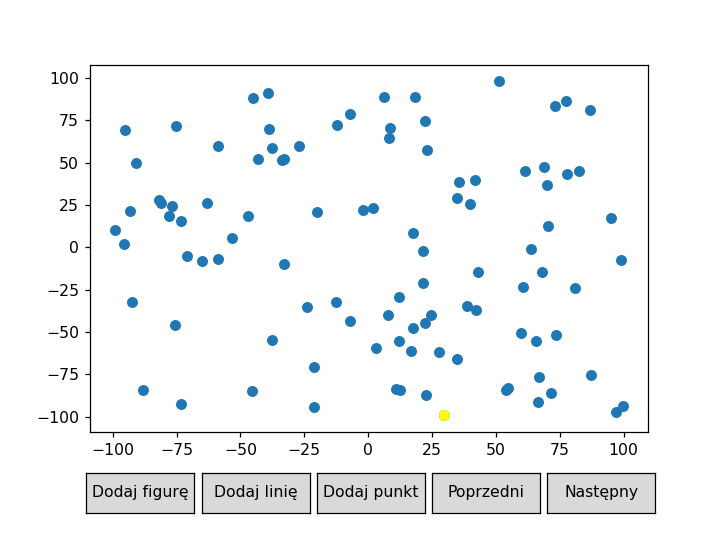

In [273]:
scenes = Jarvis(points1,True)[1]
plot = Plot(scenes)
plot.draw()

In [274]:
start = time.time()
stock = Jarvis(points1,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.005503177642822266


#### zbiór 1 b)

<IPython.core.display.Javascript object>


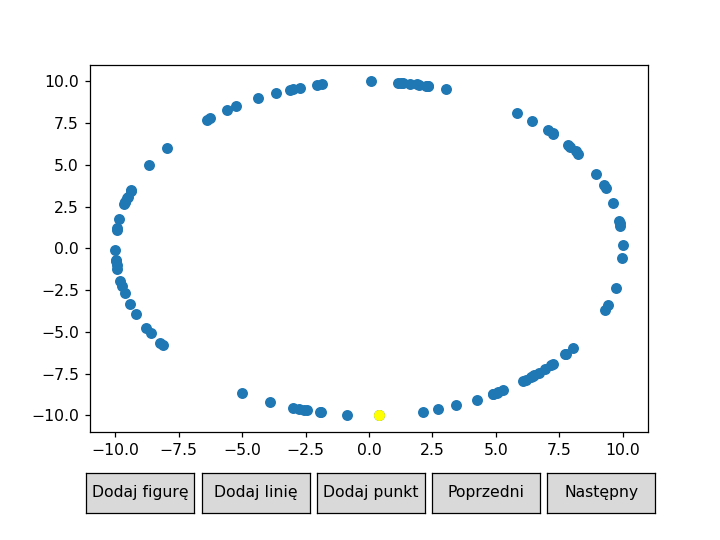

In [276]:
scenes = Jarvis(points2,True)[1]
plot = Plot(scenes)
plot.draw()

In [277]:
start = time.time()
stock = Jarvis(points2,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.03802752494812012


#### zbiór 1 c)

<IPython.core.display.Javascript object>


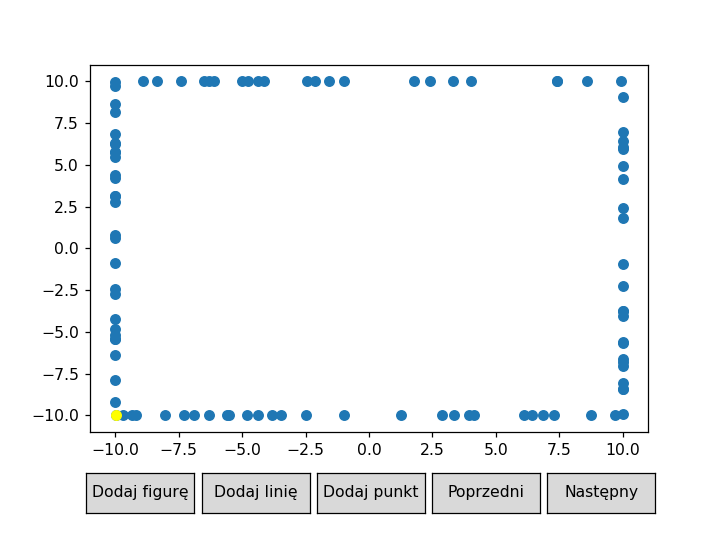

In [278]:
scenes = Jarvis(points3,True)[1]
plot = Plot(scenes)
plot.draw()

In [279]:
start = time.time()
stock = Jarvis(points3,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0039823055267333984


#### zbiór 1 d)

<IPython.core.display.Javascript object>


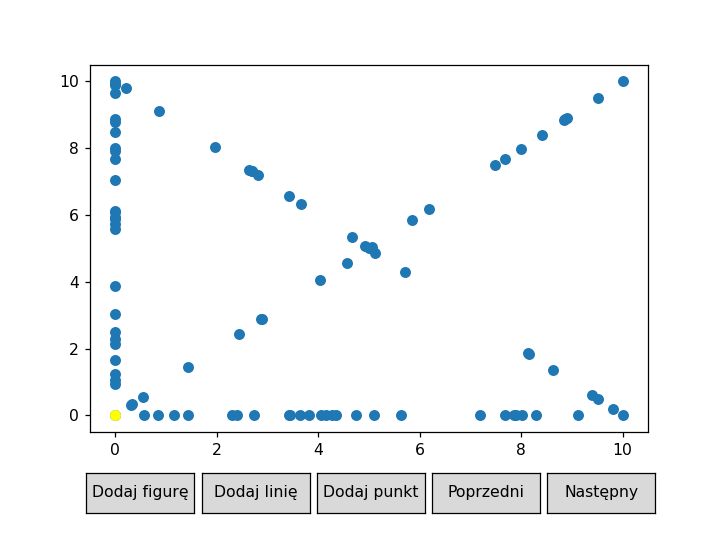

In [281]:
scenes = Jarvis(points4,True)[1]
plot = Plot(scenes)
plot.draw()

In [283]:
start = time.time()
stock = Jarvis(points4,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0030024051666259766


#### zbiór 3 a)

<IPython.core.display.Javascript object>


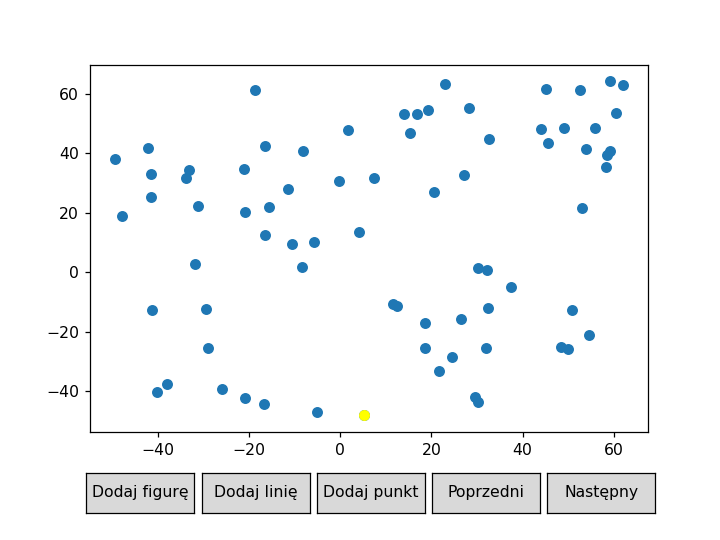

In [284]:
scenes = Jarvis(points5,True)[1]
plot = Plot(scenes)
plot.draw()

In [285]:
start = time.time()
stock= Jarvis(points5,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0030024051666259766


#### zbiór 3 b)

<IPython.core.display.Javascript object>


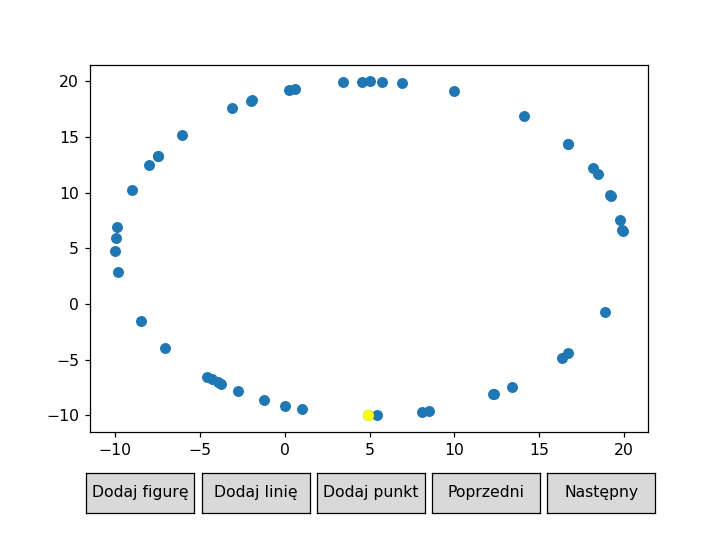

In [286]:
scenes = Jarvis(points6,True)[1]
plot = Plot(scenes)
plot.draw()

In [287]:
start = time.time()
stock = Jarvis(points6,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.011007308959960938


#### zbiór 3 c)

<IPython.core.display.Javascript object>


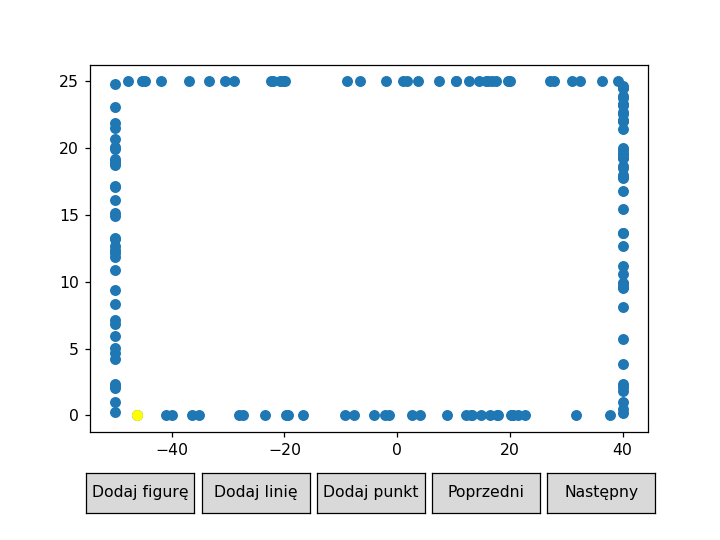

In [288]:
scenes = Jarvis(points7,True)[1]
plot = Plot(scenes)
plot.draw()

In [289]:
start = time.time()
stock = Jarvis(points7,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.003003358840942383


#### zbiór 3 d)

<IPython.core.display.Javascript object>


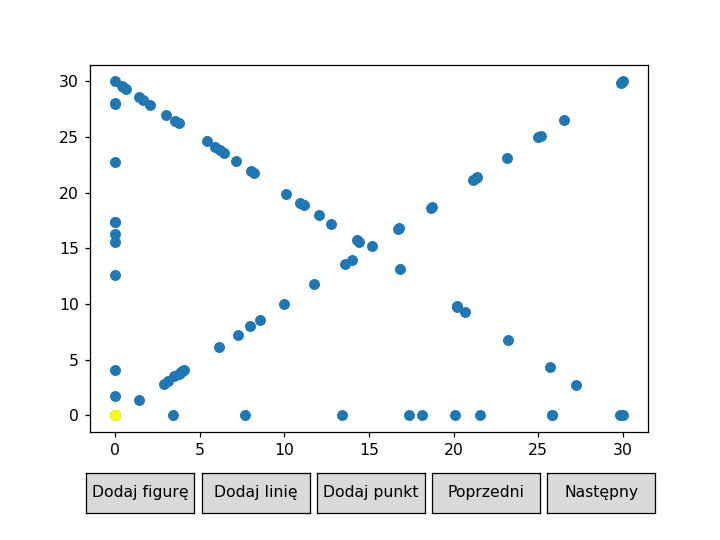

In [290]:
scenes = Jarvis(points8,True)[1]
plot = Plot(scenes)
plot.draw()

In [291]:
start = time.time()
stock = Jarvis(points8,False)[0]
end = time.time()
print('execution time: ' + str((end-start)))

execution time: 0.0020012855529785156


### Porównanie czasu działania algorytmów w zależności od liczby generowanych punktów (i-liczba punktów)

#### Algorytm Grahama

##### a) punkty o współrzędnych z przedziału [-100,100]

In [217]:
i=1000
while i<=30000:
    points=generate_random(i,-100,100)
    start=time.time()
    Graham(points,False)
    end=time.time()
    print(str((np.round((end-start),7))))
    i+=1000


0.0460324
0.2066464
0.2902057
0.3742652
0.543385
0.4673321
0.5558941
0.6009264
0.8035693
0.7105036
0.9636829
0.9506741
0.819082
1.1763332
1.1097872
1.3029242
1.1022818
1.2338753
1.5571039
1.4785495
1.7337313
1.9533854
1.9313688
1.9723973
2.3766847
2.4047058
2.3906944
2.6518812
2.5853326
2.5292943


#### b) punkty na okręgu o środku (0,0) i promieniu 10

In [230]:
i=500
while i<=7000:
    points=generate_on_circle(i,(0,0),10)
    start=time.time()
    Graham(points,False)
    end=time.time()
    print(str((end-start)))
    i+=500

0.011010169982910156
0.01564812660217285
0.0312504768371582
0.12498235702514648
0.1506803035736084
0.1941509246826172
0.18863224983215332
0.09740114212036133
0.12498116493225098
0.14064741134643555
0.1718592643737793
0.20833230018615723
0.20312809944152832
0.1875014305114746


#### c) pukty na prostokącie o wierzchołkach w punktach (-10,-10),(-10,10),(10,-10),(10,10)

In [219]:
i=1000
while i<=30000:
    points=generate_on_rectangle(i,(-10,-10),(-10,10),(10,-10),(10,10))
    start=time.time()
    Graham(points,False)
    end=time.time()
    print(str((end-start)))
    i+=1000

0.06804823875427246
0.2622358798980713
0.2731935977935791
0.24617314338684082
0.37766289710998535
0.27933597564697266
0.401658296585083
0.6277151107788086
0.7160069942474365
0.6609697341918945
0.9417116641998291
0.8135707378387451
0.8735218048095703
0.7484464645385742
1.1359946727752686
1.5263755321502686
0.931220293045044
1.1556799411773682
1.4006197452545166
2.7199296951293945
2.4568214416503906
3.110705614089966
2.2520992755889893
1.4556553363800049
1.513977289199829
1.6472141742706299
2.0279390811920166
1.8454475402832031
1.7075629234313965
2.1011745929718018


#### d) punkty na kwadracie o wierzchołkach w punktach (0,0),(0,10),(10,0),(10,10) 
#### Na każdym boku leżącym na osi wygenerowana ok. 1/4 ze wszystkich punktów, a na każdej przekątnej ok. 1/5

In [222]:
i=1000
while i<=30000:
    points=generate_on_square(i//4,i//5,(0,0),(0,10),(10,0),(10,10))
    start=time.time()
    Graham(points,False)
    end=time.time()
    print(str((end-start)))
    i+=1000

0.06304264068603516
0.10812115669250488
0.20151805877685547
0.2167212963104248
0.40785717964172363
0.4298892021179199
0.653573751449585
0.578561544418335
0.7993259429931641
0.8880419731140137
0.7667014598846436
0.9958901405334473
1.0356450080871582
1.1071193218231201
1.2072765827178955
1.2730698585510254
1.694044828414917
1.4053432941436768
1.6085405349731445
1.548457384109497
2.3602030277252197
1.9830904006958008
2.113121271133423
1.8408033847808838
2.014899253845215
2.094102621078491
2.1934926509857178
2.1383039951324463
2.3676095008850098
2.6455495357513428


#### Algorytm Jarvisa

##### a) punkty o współrzędnych z przedziału [-100,100]

In [224]:
i=1000
while i<=30000:
    points=generate_random(i,-100,100)
    start=time.time()
    Jarvis(points,False)
    end=time.time()
    print(str((np.round((end-start),7))))
    i+=1000


0.0600438
0.1363649
0.1732411
0.3104954
0.23967
0.4432337
0.4464278
0.423413
0.5388486
0.719573
0.6688228
0.9179585
0.948545
0.805886
1.1202564
1.1129541
0.8861616
0.8150575
1.0378332
0.9673474
0.8281989
1.1626318
1.2793036
1.4954188
1.1633241
1.4816387
1.8794024
1.2594647
1.6459537
1.3783157


#### b) punkty na okręgu o środku (0,0) i promieniu 10

In [229]:
i=500
while i<=7000:
    points=generate_on_circle(i,(0,0),10)
    start=time.time()
    Jarvis(points,False)
    end=time.time()
    print(str((end-start)))
    i+=500

0.5132896900177002
1.8245570659637451
4.295803785324097
8.183947324752808
12.079980373382568
17.52339458465576
26.040287971496582
31.804292678833008
41.2288122177124
62.45831489562988
62.46637511253357
94.12326431274414
84.20523929595947
104.67929458618164


#### c) pukty na prostokącie o wierzchołkach w punktach (-10,-10),(-10,10),(10,-10),(10,10)

In [226]:
i=1000
while i<=30000:
    points=generate_on_rectangle(i,(-10,-10),(-10,10),(10,-10),(10,10))
    start=time.time()
    Jarvis(points,False)
    end=time.time()
    print(str((end-start)))
    i+=1000

0.04603266716003418
0.13613486289978027
0.09213685989379883
0.09404683113098145
0.0978083610534668
0.14654231071472168
0.15310955047607422
0.16711854934692383
0.19423413276672363
0.3615262508392334
0.23437857627868652
0.25002360343933105
0.26368236541748047
0.2812321186065674
0.3897099494934082
0.4979996681213379
0.48620176315307617
0.4694552421569824
0.5522480010986328
0.5844860076904297
0.8727850914001465
1.0387368202209473
0.5678822994232178
0.5817813873291016
0.7953314781188965
0.6757066249847412
0.785433292388916
0.6264922618865967
0.847994327545166
0.930844783782959


#### d) punkty na kwadracie o wierzchołkach w punktach (0,0),(0,10),(10,0),(10,10) 
#### Na każdym boku leżącym na osi wygenerowana ok. 1/4 ze wszystkich punktów, a na każdej przekątnej ok. 1/5

In [232]:
i=1000
while i<=30000:
    points=generate_on_square(i//4,i//5,(0,0),(0,10),(10,0),(10,10))
    start=time.time()
    Jarvis(points,False)
    end=time.time()
    print(str((end-start)))
    i+=1000

0.014009237289428711
0.021016836166381836
0.03702378273010254
0.0480351448059082
0.032700538635253906
0.046875953674316406
0.06250143051147461
0.08874154090881348
0.11007499694824219
0.08035445213317871
0.10274195671081543
0.11971902847290039
0.14312243461608887
0.14286208152770996
0.1408700942993164
0.21606659889221191
0.20313048362731934
0.1904444694519043
0.2707657814025879
0.23200702667236328
0.21827030181884766
0.2187516689300537
0.21877288818359375
0.2357630729675293
0.23166275024414062
0.2500014305114746
0.2545197010040283
0.2810502052307129
0.3801865577697754
0.32813024520874023
